# Descriptive statistics of Covid-19 case numbers in German federal states

This notebook uses a dictionary data structure to automate the computation of differerent indicators and graphs by German states. This approach is highly scalable and can also be applied to smaler units such as 'Landkreise' (districts/counties) and 'Stadtkreise' (cities).

In [422]:
import pandas as pd
import numpy as np
import datetime
import sys

## Load and proprocess dataframe from RKI website

Aggregates latest RKI Covid-19 case numbers in Germany that were downloaded from:
https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

**Note:** This workbook is updated by downloading the Covid-19 case numbers as csv from the link above and saving it in the folder 'data' since the RKI API was not working at the time this code was written.

In [423]:
RKI_raw_numbers = pd.read_csv('data/RKI_COVID19.csv')

In [424]:
RKI_raw_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327698 entries, 0 to 327697
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   FID                   327698 non-null  int64 
 1   IdBundesland          327698 non-null  int64 
 2   Bundesland            327698 non-null  object
 3   Landkreis             327698 non-null  object
 4   Altersgruppe          327698 non-null  object
 5   Geschlecht            327698 non-null  object
 6   AnzahlFall            327698 non-null  int64 
 7   AnzahlTodesfall       327698 non-null  int64 
 8   Meldedatum            327698 non-null  object
 9   IdLandkreis           327698 non-null  int64 
 10  Datenstand            327698 non-null  object
 11  NeuerFall             327698 non-null  int64 
 12  NeuerTodesfall        327698 non-null  int64 
 13  Refdatum              327698 non-null  object
 14  NeuGenesen            327698 non-null  int64 
 15  AnzahlGenesen    

In [425]:
relevant_columns = ['Bundesland', 'Landkreis', 'AnzahlFall', 'AnzahlTodesfall', 'Meldedatum']

In [426]:
df_RKI = RKI_raw_numbers[relevant_columns].copy()

In [427]:
# change format of "Meldedatum" into datetime format
df_RKI['Date'] = pd.to_datetime(df_RKI['Meldedatum'], dayfirst=True)
del df_RKI['Meldedatum']

In [428]:
# Data status (i.e., date of latest available case numbers)
df_RKI.Date.max()

Timestamp('2020-10-27 00:00:00')

In [429]:
df_RKI

,Bundesland,Landkreis,AnzahlFall,AnzahlTodesfall,Date
0,Schleswig-Holstein,SK Flensburg,1,0,2020-09-30
1,Schleswig-Holstein,SK Flensburg,1,0,2020-08-24
2,Schleswig-Holstein,SK Flensburg,1,0,2020-09-26
3,Schleswig-Holstein,SK Flensburg,1,0,2020-09-25
4,Schleswig-Holstein,SK Flensburg,1,0,2020-09-26
...,...,...,...,...,...
327693,Thüringen,LK Altenburger Land,1,0,2020-10-25
327694,Thüringen,LK Altenburger Land,1,0,2020-10-25
327695,Thüringen,LK Altenburger Land,1,0,2020-10-26
327696,Thüringen,LK Altenburger Land,7,0,2020-10-27


In [430]:
# Total aggregated case numbers in Germany based on RKI data
df_RKI.AnzahlFall.sum()

464102

## Load popuation data from federal statistical office

Data source: Statistisches Bundesamt https://de.statista.com/statistik/daten/studie/71085/umfrage/verteilung-der-einwohnerzahl-nach-bundeslaendern/

In [431]:
# Read a csv file containing the German states and their populations 
df_state_population = pd.read_csv('data/Population_German_states_2019.csv')

In [432]:
df_state_population

,State,Population_in_tsd
0,Nordrhein-Westfalen,17947
1,Bayern,13125
2,Baden-Württemberg,11100
3,Niedersachsen,7994
4,Hessen,6288
5,Rheinland-Pfalz,4094
6,Sachsen,4072
7,Berlin,3669
8,Schleswig-Holstein,2904
9,Brandenburg,2522


In [433]:
population_Germany_in_tsd = df_state_population.Population_in_tsd.sum()

## Aggregate new Covid-19 cases for Germany

In [434]:
#Aggregate to Germany
df_Covid = df_RKI.groupby(['Date']).AnzahlFall.agg(['sum']).reset_index().sort_values(['Date'],ascending=[True]).rename(columns = {'sum':'New_Covid19_cases_DE'}).copy()

### Calculate 7-days moving averages for Germany 

Note: For moving average of any date, latest data taken into consideration is from previous day to account for potential delays in reporting of new cases.

In [435]:
# Convert into time series: set Date as index, set frequency to daily, fillna
df_Covid.set_index('Date', inplace=True)
df_Covid = df_Covid.sort_index().asfreq('D')
df_Covid['New_Covid19_cases_DE'] = df_Covid['New_Covid19_cases_DE'].fillna(0)

# Only consider data from 1 day ago (to account for potential for delay in reporting)
df_Covid["Shift_1"] = df_Covid['New_Covid19_cases_DE'].shift(1).fillna(0)
df_Covid['nCovid_av_DE'] = df_Covid['Shift_1'].rolling(window=7).mean().fillna(0)
del df_Covid['Shift_1'] 

In [436]:
# Dailay cases of past week (note: 7-day moving average is calculated as average of previous 7 days, hereby excluding current day)
df_Covid.tail(7)

,New_Covid19_cases_DE,nCovid_av_DE
Date,,
2020-10-21,12231.0,6872.000000
2020-10-22,13636.0,7587.857143
2020-10-23,13668.0,8411.428571
2020-10-24,10807.0,9232.428571
2020-10-25,7260.0,9966.714286
2020-10-26,10742.0,10479.142857
2020-10-27,9436.0,11100.142857


### Plot 7-days moving average for Germany

<AxesSubplot:title={'center':'Daily Covid cases Germany'}, xlabel='Date'>

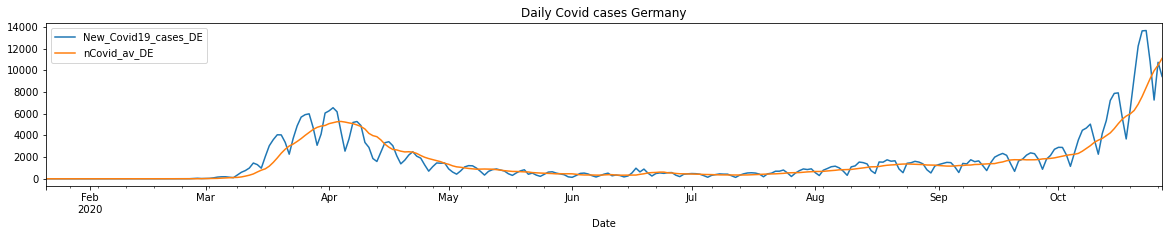

In [437]:
df_Covid.plot(figsize=(20,3), title="Daily Covid cases Germany")

### Calculate average new cases per 100k population in Germany

In [438]:
df_Covid['New_av_cases_per_100k_DE'] = df_Covid.nCovid_av_DE/population_Germany_in_tsd*100

In [439]:
df_Covid.tail(7)

,New_Covid19_cases_DE,nCovid_av_DE,New_av_cases_per_100k_DE
Date,,,
2020-10-21,12231.0,6872.000000,8.262992
2020-10-22,13636.0,7587.857143,9.123749
2020-10-23,13668.0,8411.428571,10.114023
2020-10-24,10807.0,9232.428571,11.101206
2020-10-25,7260.0,9966.714286,11.984121
2020-10-26,10742.0,10479.142857,12.600273
2020-10-27,9436.0,11100.142857,13.346972


<AxesSubplot:title={'center':'Average daily new Covid-19 cases in Germany per 100k population'}, xlabel='Date'>

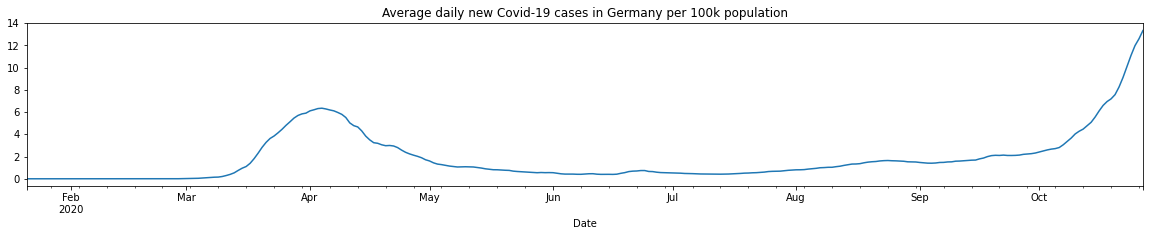

In [440]:
df_Covid.New_av_cases_per_100k_DE.plot(figsize=(20,3), title='Average daily new Covid-19 cases in Germany per 100k population')

# Descriptive statistics of Covid-19 cases for all federal states

In [441]:
# FYI: names of German federal states (note that spelling is the same as in the data from the Federal Statistics Office)
States = list(df_RKI.Bundesland.unique())

## Create a dictionary with relevant information per state

The data structure of a dictionary is advantageous in order to automate the calculation of indicators per state (the keys will be the names of the 16 federal states). Automation is in the form of a loop.

In [442]:
# Initiate a list with the state names which will be the keys of the dict
list_states = list(df_state_population.State)

In [443]:
# Initate a list of population per state as well as a list of state abbreviations which are going to be values in the dictionary
list_state_population_tsd = list(df_state_population.Population_in_tsd)
list_state_abbrev = ['NW', 'BY', 'BW', 'NI', 'HE', 'RP', 'SN', 'BE', 'SH', 'BB', 'ST', 'TH', 'HH', 'MV', 'SL', 'HB' ]

In [444]:
# In order to make sure that both the population in each state as well as the abbreviation will be values of 
# the dict, create a list of tuples
list_of_tuples = list(zip(list_state_population_tsd,list_state_abbrev))
# Convert the list of tuples into a list of lists
list_of_list = list(map(list,list_of_tuples))

# Create the dictionary 
state_dict = dict(zip(list_states,list_of_list))

In [445]:
# Create a another value for each state: The name of a df with its Covid19 cases
for key, value in state_dict.items():
    name_df = 'df'+'_'+value[1] 
    state_dict[key].append(name_df)

In [446]:
# This is the strucutre of the dictionary
state_dict

{'Nordrhein-Westfalen': [17947, 'NW', 'df_NW'],
 'Bayern': [13125, 'BY', 'df_BY'],
 'Baden-Württemberg': [11100, 'BW', 'df_BW'],
 'Niedersachsen': [7994, 'NI', 'df_NI'],
 'Hessen': [6288, 'HE', 'df_HE'],
 'Rheinland-Pfalz': [4094, 'RP', 'df_RP'],
 'Sachsen': [4072, 'SN', 'df_SN'],
 'Berlin': [3669, 'BE', 'df_BE'],
 'Schleswig-Holstein': [2904, 'SH', 'df_SH'],
 'Brandenburg': [2522, 'BB', 'df_BB'],
 'Sachsen-Anhalt': [2195, 'ST', 'df_ST'],
 'Thüringen': [2133, 'TH', 'df_TH'],
 'Hamburg': [1847, 'HH', 'df_HH'],
 'Mecklenburg-Vorpommern': [1608, 'MV', 'df_MV'],
 'Saarland': [987, 'SL', 'df_SL'],
 'Bremen': [681, 'HB', 'df_HB']}

## Aggregate and smoothe the Covid19 cases for each state

**Import an aggregation function from the sys folder**

(Note: For easier reference, the code of the function can also be found in the appendix of this notebook)

In [447]:
# The function calculates the daily absolute and 7-days average new cases number for each state
sys.path.append('./src')
import aggregation_functions

**Create a separate dataframe for each federal state**

In [448]:
# Loop through the dictionary in oder to define a separate dataframe for each federal state
for key, value in state_dict.items():
    state_dict[key][2] = aggregation_functions.aggregate_to_state(df_RKI, key, value[1])

**Calculate cases per 100,000 inhabitants per state**

In the dictionary, for each German federal state, there is now one dataframe with its Covid case numbers, i.e. the strucutre of the dictionary is as follows:

state_dict = {name of the state: [number of inhabitants in tsd, state abbreviation, state dataframe],....}

I.e., the dataframe of one particular state can be accessed like this: state_dict[key][2]

This dictionary structure allows looping through all German states to calculate state specific indicators, such as average new cases per 100,000 inhabitants:

In [449]:
# example state dataframe
state_dict['Bayern'][2].tail()

,New_Covid19_cases_BY,nCovid_av_BY
Date,,
2020-10-23,2070.0,1396.000000
2020-10-24,1623.0,1513.000000
2020-10-25,1364.0,1604.571429
2020-10-26,2185.0,1716.857143
2020-10-27,2074.0,1876.285714


In [450]:
# In each dataframe, include a new column that shows the 7-days average number of new Covid19 cases per 100k inhabitants
for key, value in state_dict.items():
    # This create a new column in each dataframe                      # Here, the average new cases (selected with the iloc method) are divided by the population per state times 100,000
    state_dict[key][2]['New_av_cases_per_100k_'+state_dict[key][1]] = state_dict[key][2].iloc[:, [False, True]]/(state_dict[key][0])*100    

## Plot the Covid19 cases for each federal state

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


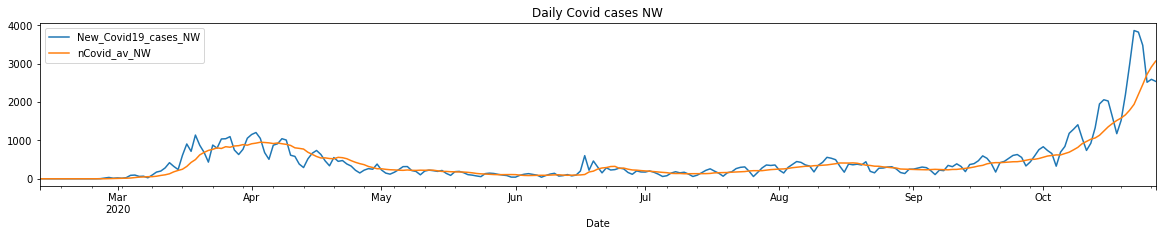

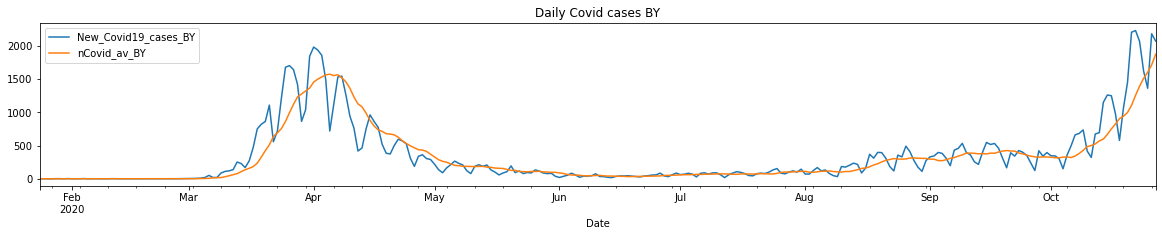

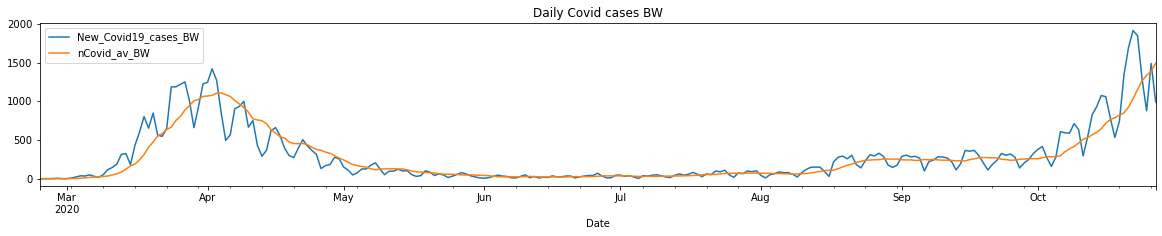

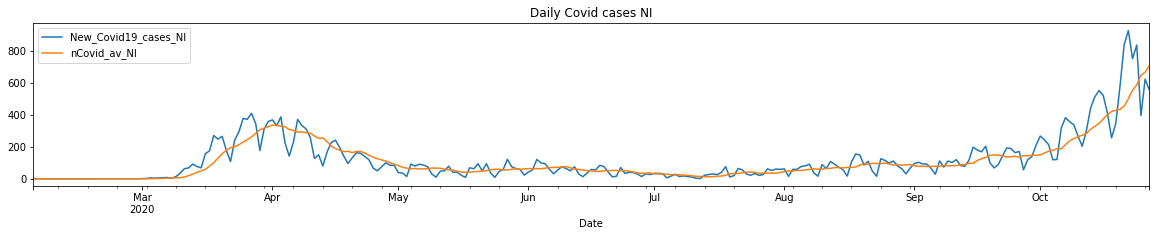

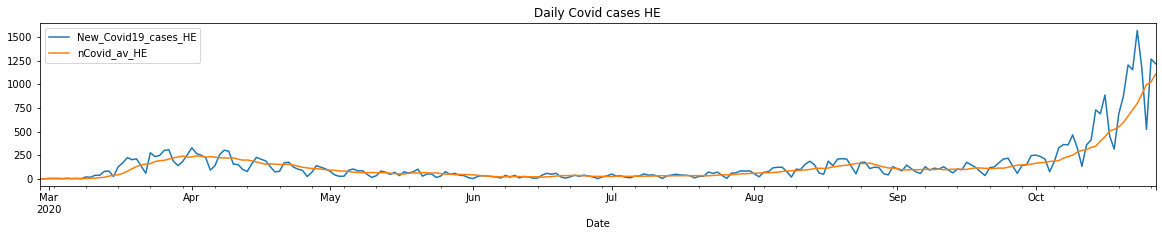

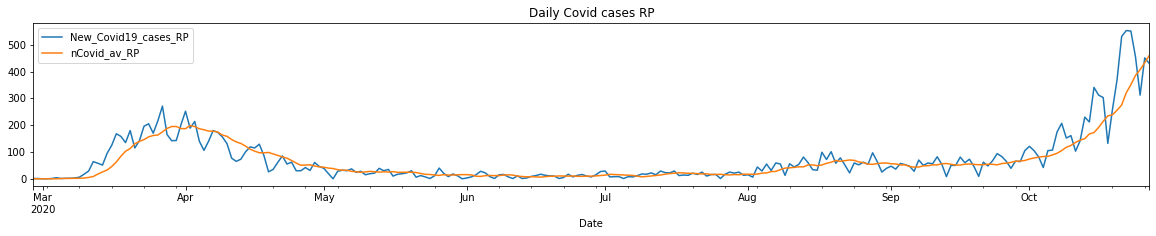

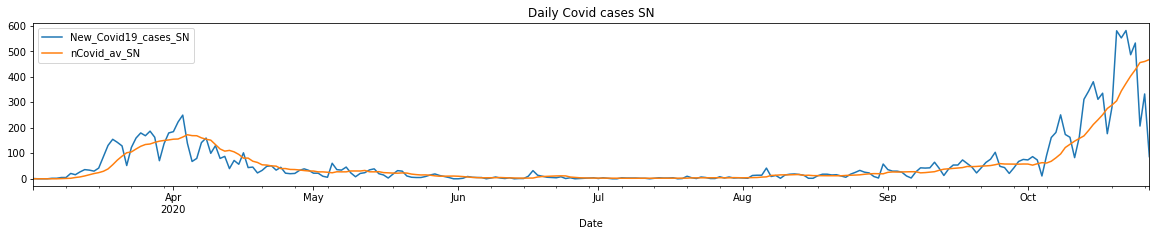

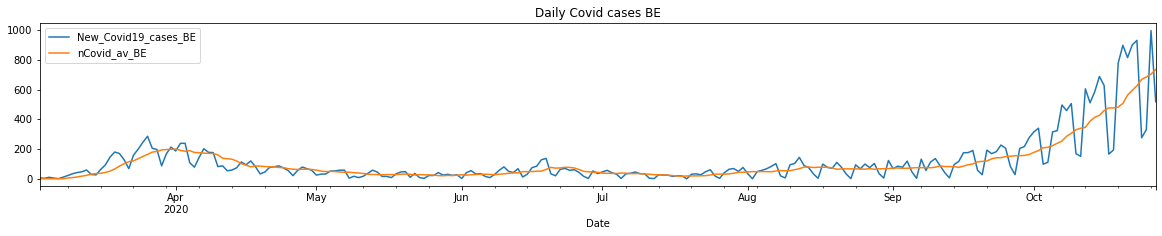

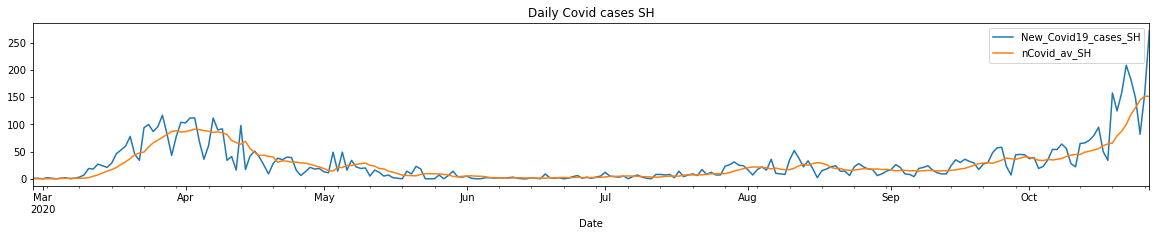

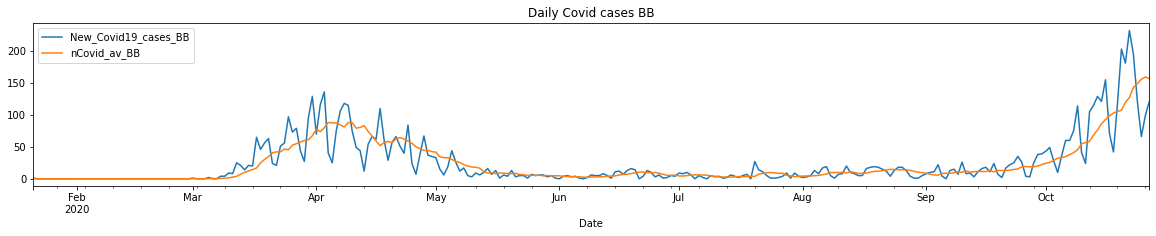

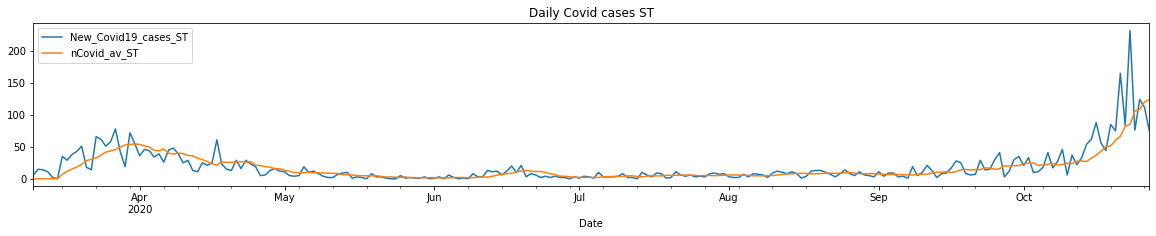

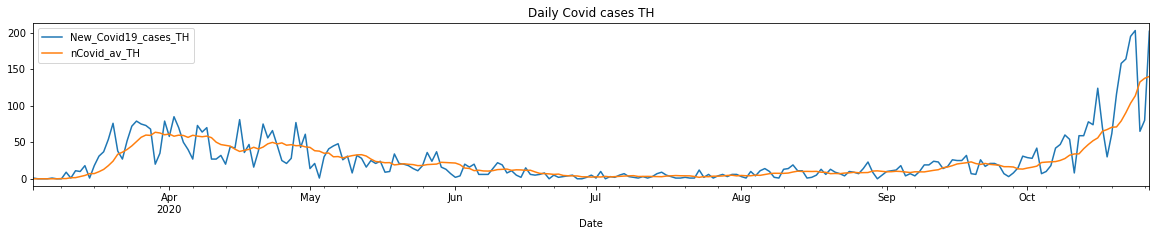

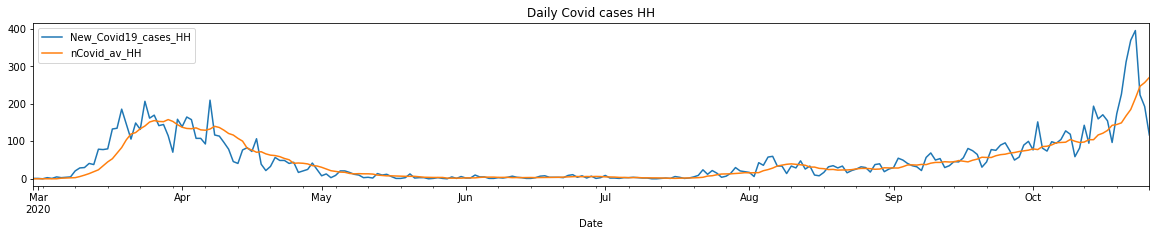

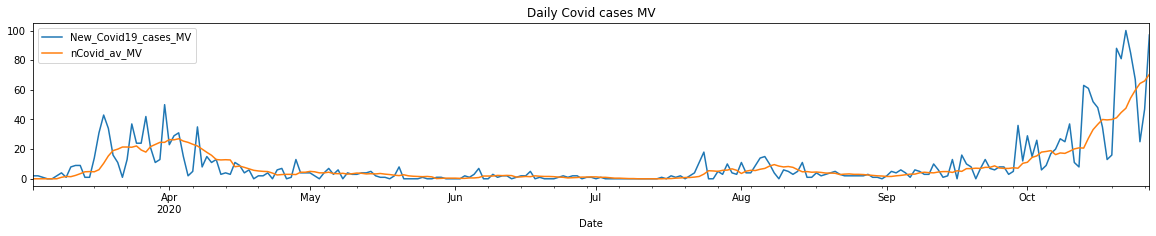

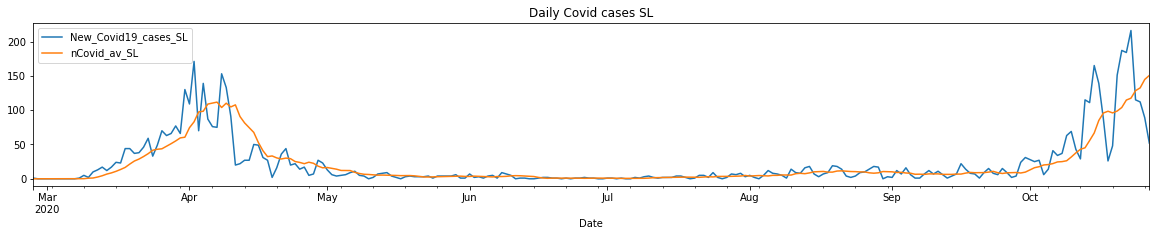

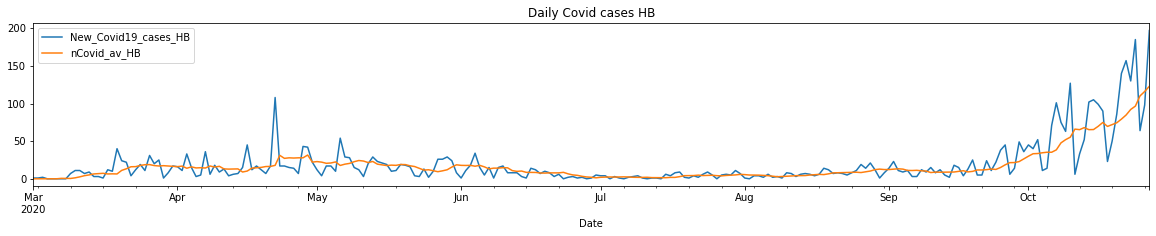

In [451]:
for key, value in state_dict.items():
    print(state_dict[key][2].iloc[:,[True, True, False]].plot(figsize=(20,3), title=("Daily Covid cases "+ state_dict[key][1])))

## Plot evolution of new covid cases per 100k population across German states

**Merge per capita (100k) case numbers of states into Germany dataframe**

In [452]:
for key, value in state_dict.items():
    df_Covid = pd.merge(df_Covid, state_dict[key][2].iloc[:, [False, False, True]].fillna(0), left_index=True, right_index=True, how='left')

In [453]:
df_Covid.tail()

,New_Covid19_cases_DE,nCovid_av_DE,New_av_cases_per_100k_DE,New_av_cases_per_100k_NW,New_av_cases_per_100k_BY,New_av_cases_per_100k_BW,New_av_cases_per_100k_NI,New_av_cases_per_100k_HE,New_av_cases_per_100k_RP,New_av_cases_per_100k_SN,New_av_cases_per_100k_BE,New_av_cases_per_100k_SH,New_av_cases_per_100k_BB,New_av_cases_per_100k_ST,New_av_cases_per_100k_TH,New_av_cases_per_100k_HH,New_av_cases_per_100k_MV,New_av_cases_per_100k_SL,New_av_cases_per_100k_HB
Date,,,,,,,,,,,,,,,,,,,
2020-10-23,13668.0,8411.428571,10.114023,12.263888,10.636190,10.382239,6.946281,12.688568,8.577012,9.900365,17.046295,4.078119,5.670103,3.885454,4.848972,11.640498,3.384861,11.897525,13.530522
2020-10-24,10807.0,9232.428571,11.101206,13.694290,11.527619,11.395109,7.355517,14.242548,9.410985,10.514314,18.229958,4.511019,5.896681,4.822649,5.324493,13.380772,3.713575,13.012013,14.180827
2020-10-25,7260.0,9966.714286,11.984121,15.185188,12.225306,12.042471,8.113228,15.864686,9.941378,11.205445,18.658256,4.998032,6.179903,4.952815,6.215257,13.914456,3.997868,13.417282,16.173694
2020-10-26,10742.0,10479.142857,12.600273,16.252617,13.080816,12.485199,8.361628,16.339513,10.569474,11.310693,19.187790,5.234160,6.315849,5.473479,6.449668,14.656973,4.104478,14.662035,17.033774
2020-10-27,9436.0,11100.142857,13.346972,17.107515,14.295510,13.445302,8.858430,17.657216,11.242934,11.493124,20.040494,5.229240,6.213889,5.649203,6.570223,NaN,4.379886,15.255464,18.040696


**Plot of cases per 100k population**

<AxesSubplot:title={'center':'7-day moving average'}, xlabel='Date'>

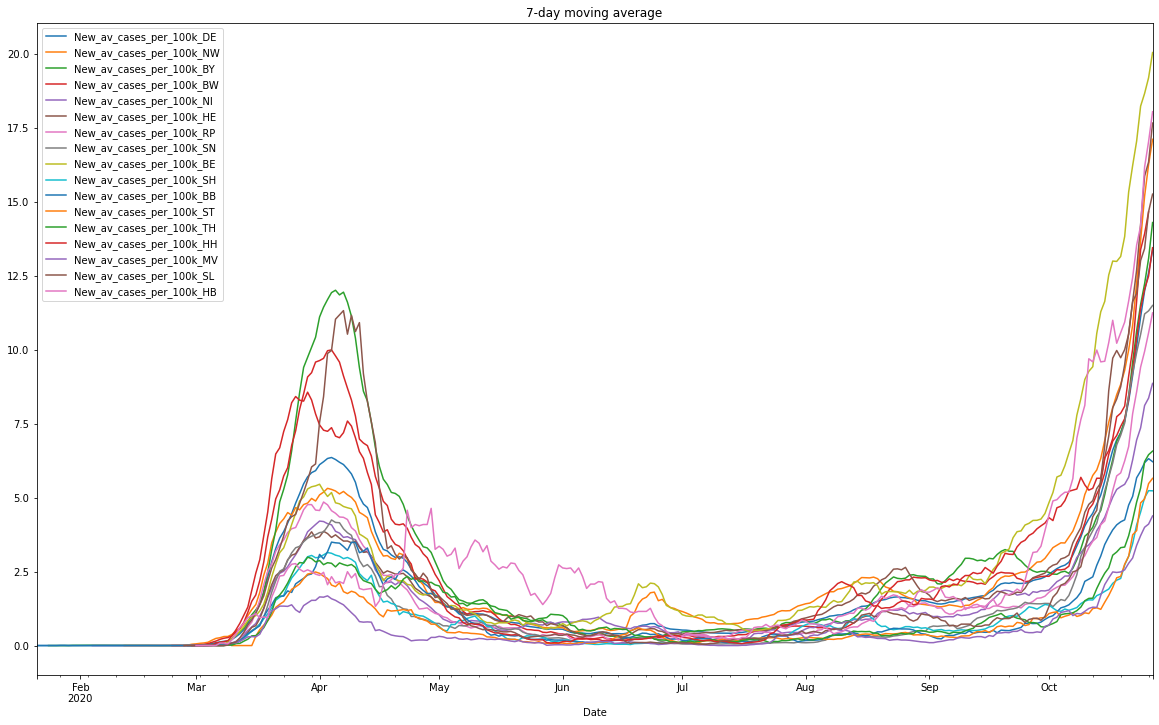

In [454]:
df_Covid.iloc[:, 2:].plot(figsize=(20,12), title='7-day moving average')

# Appendix

## Plotting of numbers for selected Landkreise and Stadtkreise

This is to ilustrate that the automation approach via dictionary and loops can easily applied to other units. 

The population sizes of all German Landkreise/Stadtkreise (districts/cites can be downloaded from https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/04-kreise.html)

In [455]:
# names of German Landkreise
df_RKI.Landkreis.unique()

array(['SK Flensburg', 'SK Kiel', 'SK Lübeck', 'SK Neumünster',
       'LK Dithmarschen', 'LK Herzogtum Lauenburg', 'LK Nordfriesland',
       'LK Ostholstein', 'LK Pinneberg', 'LK Plön',
       'LK Rendsburg-Eckernförde', 'LK Schleswig-Flensburg',
       'LK Segeberg', 'LK Steinburg', 'LK Stormarn', 'SK Hamburg',
       'SK Braunschweig', 'SK Salzgitter', 'SK Wolfsburg', 'LK Gifhorn',
       'LK Goslar', 'LK Helmstedt', 'LK Northeim', 'LK Peine',
       'LK Wolfenbüttel', 'LK Göttingen', 'Region Hannover',
       'LK Diepholz', 'LK Hameln-Pyrmont', 'LK Hildesheim',
       'LK Holzminden', 'LK Nienburg (Weser)', 'LK Schaumburg',
       'LK Celle', 'LK Cuxhaven', 'LK Harburg', 'LK Lüchow-Dannenberg',
       'LK Lüneburg', 'LK Osterholz', 'LK Rotenburg (Wümme)',
       'LK Heidekreis', 'LK Stade', 'LK Uelzen', 'LK Verden',
       'SK Delmenhorst', 'SK Emden', 'SK Oldenburg', 'SK Osnabrück',
       'SK Wilhelmshaven', 'LK Ammerland', 'LK Aurich', 'LK Cloppenburg',
       'LK Emsland', 'LK

### Create dictionary for Landkreise and their abbrebviations to be plotted

In [456]:
# Create a dictionary that contains the formal names of the LK of interest as well as an abbreviation
LK_to_be_plotted = {'SK München': ['Muenchen', 1484], 'SK Bonn': ['Bonn', 330], 'SK Düsseldorf': ['Duesseldorf', 622], 
                    'SK Frankfurt am Main': ['Frankfurt', 763], 'SK Köln': ['Koeln', 1088], 
                    'LK Rhein-Sieg-Kreis': ['SU', 601], 'LK Rottal-Inn': ['Rottal', 122]}

In [457]:
# Define the name of a df (e.g., 'df_Munenchen') and add this to the dictionary above
for key, value in LK_to_be_plotted.items():
    name_df = 'df'+'_'+value[0] 
    LK_to_be_plotted[key].append(name_df)

In [458]:
LK_to_be_plotted

{'SK München': ['Muenchen', 1484, 'df_Muenchen'],
 'SK Bonn': ['Bonn', 330, 'df_Bonn'],
 'SK Düsseldorf': ['Duesseldorf', 622, 'df_Duesseldorf'],
 'SK Frankfurt am Main': ['Frankfurt', 763, 'df_Frankfurt'],
 'SK Köln': ['Koeln', 1088, 'df_Koeln'],
 'LK Rhein-Sieg-Kreis': ['SU', 601, 'df_SU'],
 'LK Rottal-Inn': ['Rottal', 122, 'df_Rottal']}

### Plot total cases per Landkreis

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


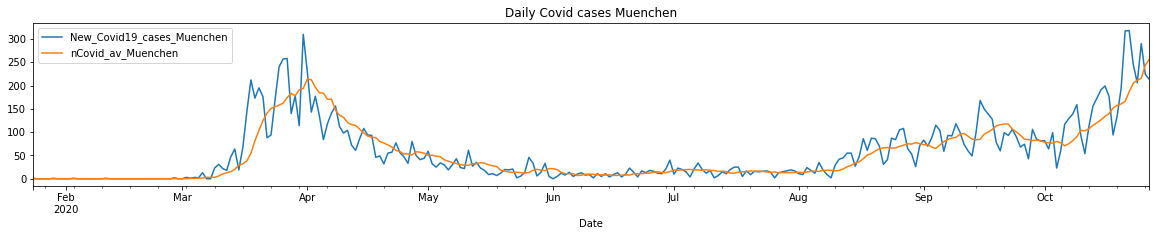

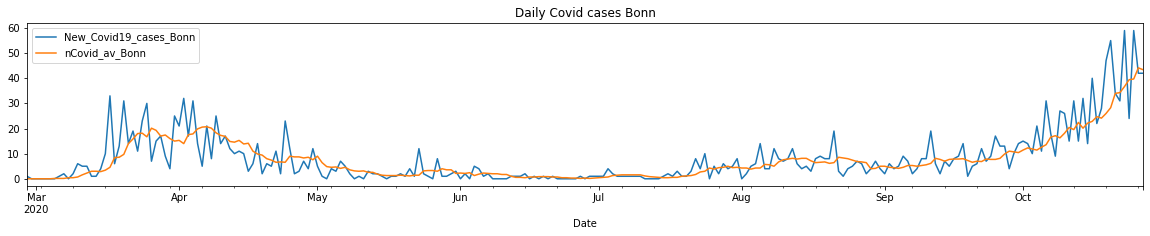

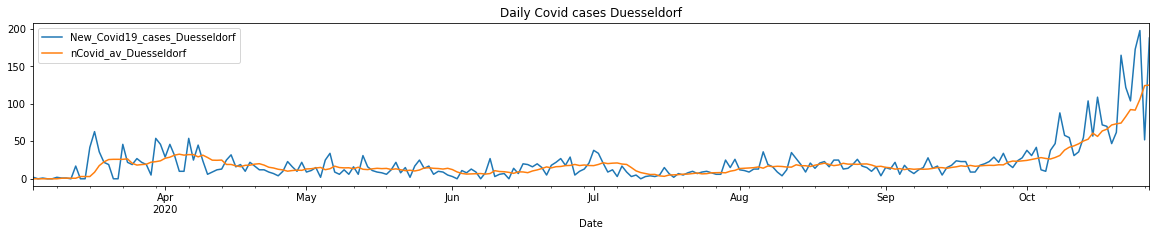

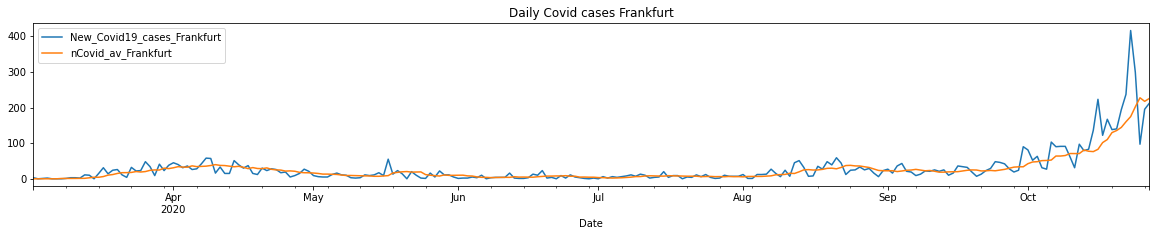

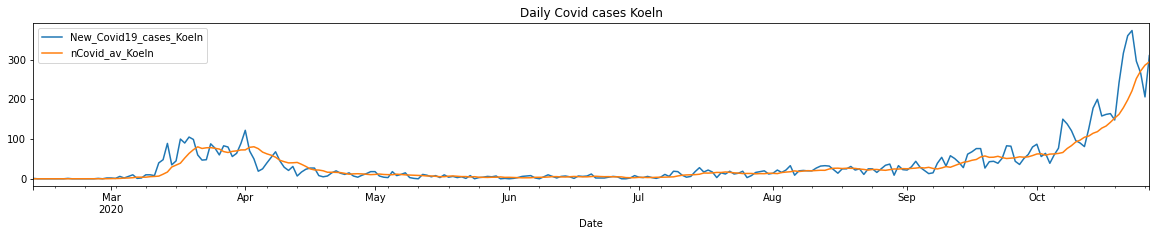

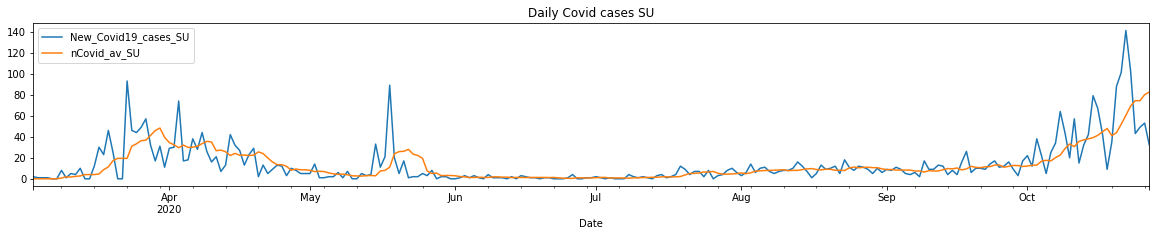

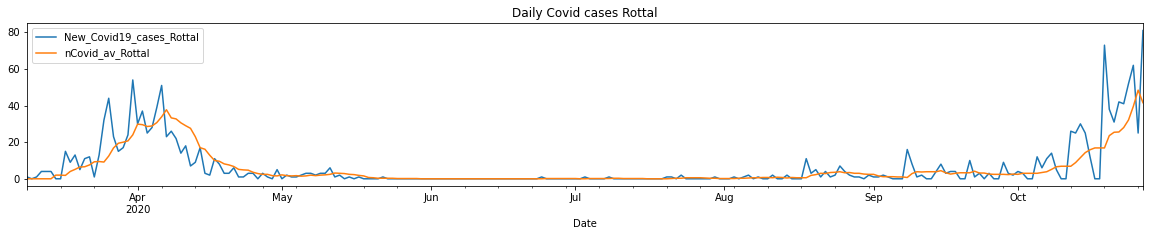

In [460]:
# Create dataframes with the aggregated Covid cases per Landkreis and store in the dict above
for key, value in LK_to_be_plotted.items():
    LK_to_be_plotted[key][2] = aggregation_functions.aggregate_to_LK(df_RKI, key, LK_to_be_plotted[key][0])
    print(LK_to_be_plotted[key][2].plot(figsize=(20,3), title=("Daily Covid cases "+ LK_to_be_plotted[key][0])))

### Plot cases per 100k population in the Landkreise/ Stadtkreise of interest

In [461]:
# Add column with Covid-19 cases per city
for key, value in LK_to_be_plotted.items():
    LK_to_be_plotted[key][2]['New_av_cases_per_100k_'+LK_to_be_plotted[key][0]] = LK_to_be_plotted[key][2].iloc[:, [False, True]]/(LK_to_be_plotted[key][1])*100    

In [462]:
# Initiate dataframe for cities/Landkreise of interest only
df_LK_of_interest = df_Covid.New_av_cases_per_100k_DE

In [463]:
# Merge 100k incidence of cities of interest into this dataframe
for key, value in LK_to_be_plotted.items():
    df_LK_of_interest = pd.merge(df_LK_of_interest, LK_to_be_plotted[key][2].iloc[:,[False, False, True]].fillna(0), left_index=True, right_index=True, how='left')

<AxesSubplot:title={'center':'100k incidence of average new Covid-19 cases in several cities'}, xlabel='Date'>

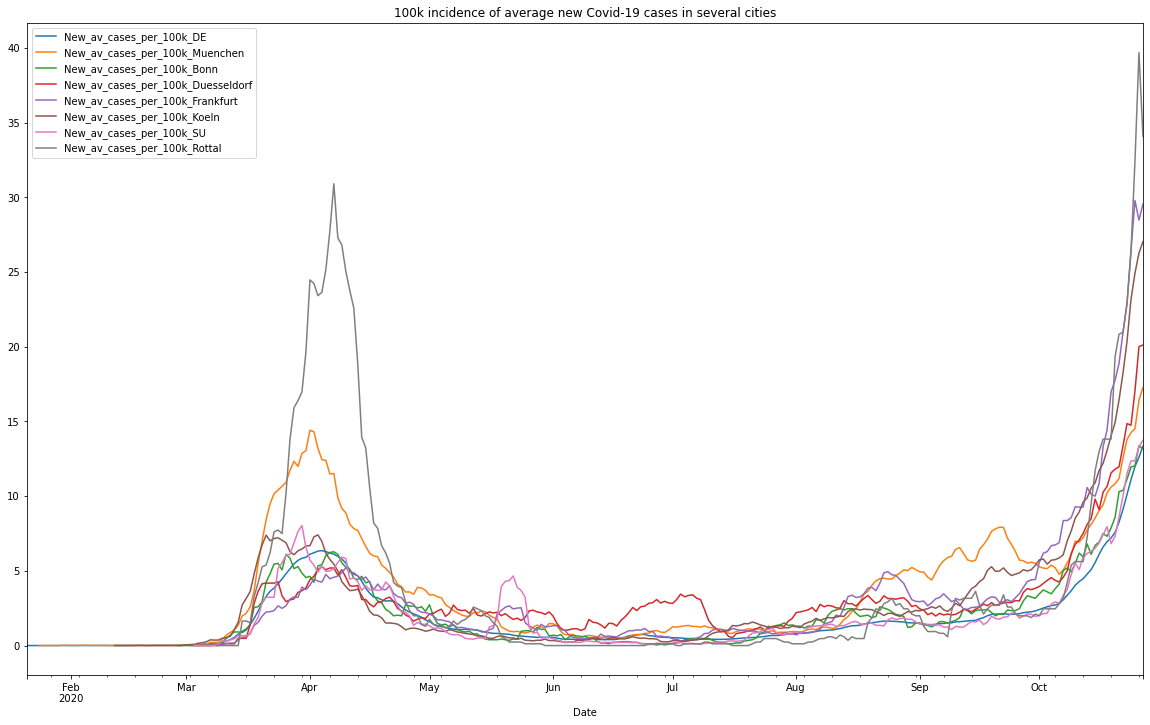

In [464]:
df_LK_of_interest.plot(figsize=(20,12), title="100k incidence of average new Covid-19 cases in several cities")

## Imported aggregation functions

For easier reference:

In [465]:
def aggregate_to_state(df_to_be_aggregated, Bundesland, Bundesland_short):
    '''
    Adds the daily new Covid-19 cases for a specific German state to df_Covid in a new column.
    I.e., it aggregates the raw data on new Covid-19 cases from RKI by day and on state level
    and filters the numbers of the state specified.
    Daily numbers are then sorted in ascending order.
    A column is added with the 7-day moving average

    Arguments: name of dataframe to be aggregated, name of Bundesland and abbreviation of Bundesland as strings

    Output: dataframe
    '''
    df = df_to_be_aggregated.groupby(['Date', 'Bundesland']).AnzahlFall.agg(['sum']).reset_index().sort_values(['Date', 'Bundesland'],ascending=[True, True]).rename(columns = {'sum':'New_Covid19_cases'+'_'+Bundesland_short}).copy()
    df_Bundesland = df.loc[df['Bundesland'] == Bundesland].copy()
    # create 7-days moving average (with 1 day time lag to account for reporting delays)
    df_Bundesland.set_index("Date", inplace=True)
    df_Bundesland = df_Bundesland.sort_index().asfreq('D')
    df_Bundesland['New_Covid19_cases_' + Bundesland_short] = df_Bundesland['New_Covid19_cases_' + Bundesland_short].fillna(0)
    df_Bundesland['Shift_1'] = df_Bundesland['New_Covid19_cases_' + Bundesland_short].shift(1).fillna(0)
    df_Bundesland['nCovid_av_' + Bundesland_short] = df_Bundesland['Shift_1'].rolling(window=7).mean().fillna(0)
    del df_Bundesland['Bundesland'], df_Bundesland['Shift_1']

    return df_Bundesland

In [466]:
def aggregate_to_LK(df_to_be_aggregated, Landkreis, Landkreis_short):
    '''
    Adds the daily new Covid-19 cases for a specific German Landkreis to df_Covid in a new column.
    I.e., it aggregates the raw data on new Covid-19 cases from RKI by day and on state level
    and filters the numbers of the state specified.
    Daily numbers are then sorted in ascending order.
    A column is added with the 7-day moving average

    Arguments: name of dataframe to be aggregated, name of Landkreis and abbreviation of Landkreis as strings

    Output: dataframe
    '''
    df = df_to_be_aggregated.groupby(['Date', 'Landkreis']).AnzahlFall.agg(['sum']).reset_index().sort_values(['Date', 'Landkreis'],ascending=[True, True]).rename(columns = {'sum':'New_Covid19_cases'+'_'+Landkreis_short}).copy()
    df_Landkreis = df.loc[df['Landkreis'] == Landkreis].copy()
    # create 7-days moving average (with 1 day time lag to account for reporting delays)
    df_Landkreis.set_index("Date", inplace=True)
    df_Landkreis = df_Landkreis.sort_index().asfreq('D')
    df_Landkreis['New_Covid19_cases_' + Landkreis_short] = df_Landkreis['New_Covid19_cases_' + Landkreis_short].fillna(0)
    df_Landkreis['Shift_1'] = df_Landkreis['New_Covid19_cases_' + Landkreis_short].shift(1).fillna(0)
    df_Landkreis['nCovid_av_' + Landkreis_short] = df_Landkreis['Shift_1'].rolling(window=7).mean().fillna(0)
    del df_Landkreis['Landkreis'], df_Landkreis['Shift_1']

    return df_Landkreis
